In [2]:
%pylab inline

import gc
import fpfs
import numpy as np
from fpfs import simutil
import scipy.ndimage as ndi
import matplotlib.pylab as plt
import astropy.io.fits as pyfits
from fpfs.imgutil import gauss_kernel

Populating the interactive namespace from numpy and matplotlib
Do not have lsst pipeline!


In [6]:
gc.collect()
igroup=0
do_plot=False
ngrid=64
if igroup>=0:
    ngal=100
    img1=pyfits.getdata('../../FPFS2/sim/galaxy_basicShift_psf60/image-%d-g1-0000.fits' %igroup)
    img2=pyfits.getdata('../../FPFS2/sim/galaxy_basicShift_psf60/image-%d-g1-2222.fits' %igroup)
else:
    ngal=20
    img1=simutil.make_basic_sim('basicShift_psf60','g1-0000',0,ny=ngal,nx=ngal,do_write=False)
    img2=simutil.make_basic_sim('basicShift_psf60','g1-2222',0,ny=ngal,nx=ngal,do_write=False)
ngrid2=ngrid*ngal

# PSF
psf=pyfits.getdata('../../FPFS2/sim/galaxy_basic_psf60/psf-60.fits')
npad       =   (ngrid2-psf.shape[0])//2
psfData    =   np.pad(psf,(npad+1,npad),mode='constant')
assert psfData.shape[0]==ngrid2
psfF=np.fft.fft2(np.fft.ifftshift(psfData))
gsigma=3.*2.*np.pi/64
x   = np.fft.fftfreq(ngrid2,1/np.pi/2.)

gKer,grids=gauss_kernel(ngrid2,ngrid2,gsigma,return_grid=True)
k2grid,k1grid=grids

imgF1=np.fft.fft2(img1)/psfF*gKer
imgFQA1=imgF1*(k1grid**2.-k2grid**2.)/gsigma**2.
imgFQB1=imgF1*(2.*k1grid*k2grid)/gsigma**2.
imgFDA1=imgF1*(-1j*k1grid)
imgFDB1=imgF1*(-1j*k2grid)

imgF2=np.fft.fft2(img2)/psfF*gKer
imgFQA2=imgF2*(k1grid**2.-k2grid**2.)/gsigma**2.
imgFQB2=imgF2*(2.*k1grid*k2grid)/gsigma**2.
imgFDA2=imgF2*(-1j*k1grid)
imgFDB2=imgF2*(-1j*k2grid)

imgCov1=np.fft.ifft2(imgF1).real
imgCovQA1=np.fft.ifft2(imgFQA1).real
imgCovQB1=np.fft.ifft2(imgFQB1).real
imgCovDA1=np.fft.ifft2(imgFDA1).real
imgCovDB1=np.fft.ifft2(imgFDB1).real

imgCov2=np.fft.ifft2(imgF2).real
imgCovQA2=np.fft.ifft2(imgFQA2).real
imgCovQB2=np.fft.ifft2(imgFQB2).real
imgCovDA2=np.fft.ifft2(imgFDA2).real
imgCovDB2=np.fft.ifft2(imgFDB2).real

indX=np.arange(32,6400,64)
indY=np.arange(32,6400,64)
ind1=np.ix_(indY,indX)
ind2=np.ix_(indY,indX)

res1=imgCovQA1[ind1]#+0.5*imgCovDA1[ind1]-0.5*imgCovDB1[ind1]
res2=imgCovQA2[ind2]#+0.5*imgCovDA2[ind2]-0.5*imgCovDB2[ind2]
response=np.average((res1+res2)/2.)
meas1=imgCov1[ind1]
meas2=imgCov2[ind2]
resEst=np.average((meas2-meas1)/0.04)

In [25]:
npixt = 1
sizet = 1 + 2 * npixt

footprint = np.zeros((sizet, sizet))
footprint[npixt, npixt] = 1.
footprint[npixt+1, npixt] = -1.
imgCovACov1=ndi.convolve(imgCov1,footprint,mode='constant')


footprint = np.ones((sizet, sizet))
footprint[npixt, npixt] = 0
filtered=ndi.maximum_filter(imgCov1,size=(sizet,sizet),footprint=footprint,mode='constant')
mask_local_maxima = (imgCov1 > filtered)
coords = np.int_(np.asarray(np.where(mask_local_maxima)).T)
gc.collect()

/lustre/work/xiangchong.li/ana/miniconda3/envs/cosmosis-mpich/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: ignoring size because footprint is set
  if sys.path[0] == '':


51563

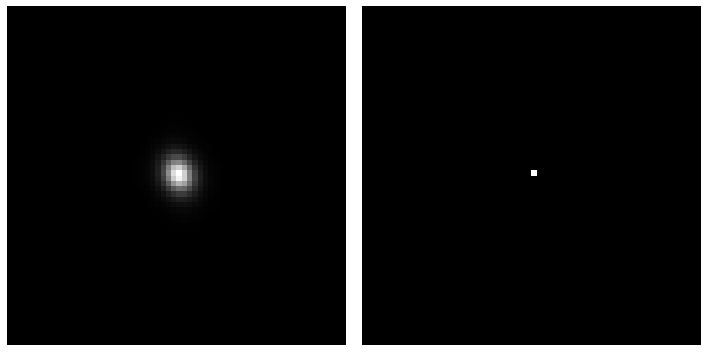

In [15]:
plt.close()
dpad=0
ii=1;jj=4
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(1,2,1)
ax.imshow(img1[jj*64+dpad:(jj+1)*64-dpad,ii*64+dpad:(ii+1)*64-dpad],origin='lower',cmap='gray')
ax.set_axis_off()
ax=fig.add_subplot(1,2,2)
ax.imshow(mask_local_maxima[jj*64+dpad:(jj+1)*64-dpad,ii*64+dpad:(ii+1)*64-dpad],origin='lower',cmap='gray')
ax.set_axis_off()
plt.tight_layout()

3132


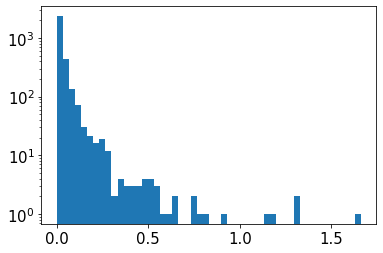

In [24]:
thres=3.*np.sqrt(7e-3)
plt.close()
plt.hist(np.ravel(imgCovACov1[(imgCov1>thres)&(mask_local_maxima)]),bins=50)
plt.yscale('log')
print(np.sum((imgCov1>thres)&mask_local_maxima))

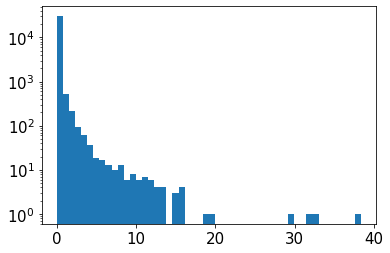

In [27]:
plt.close()
plt.hist(np.ravel(imgCov1[mask_local_maxima]),bins=50)
plt.yscale('log')